In [50]:
from pathlib import Path

import dask.array as da
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pywt
import torch
from scipy.signal import butter, filtfilt


## Source distributions

`source_mode` selects which sources should excite the original wavefield. Choices are `"boundary"`, `"isolated"`, and `"both"`. For details, see the manuscript.

To reproduce all figures, run the full notebook for each `source_mode` once to compute and save all required correlations.

In [51]:
# source_mode = "boundary"
# source_mode = "isolated"
source_mode = "both"
synthetic = False

## Load Geometry

[(-11.0, 11.0), (-8.0, 7.0), None]

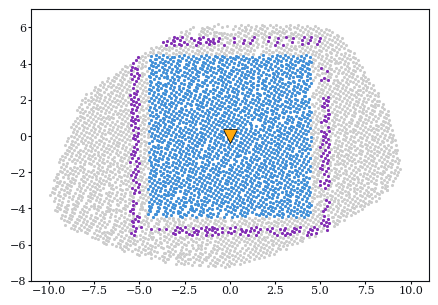

In [52]:
plt.style.use(Path("../meta/colorblind_friendly.mplstyle"))
matplotlib.rcParams.update({"font.family": "serif", "font.size": 8})


# station locations
stationlist_all = pl.read_csv("../meta/stations_all.csv")
stations_all = torch.tensor(
    np.vstack((stationlist_all["X"].to_numpy(), stationlist_all["Y"].to_numpy())).T
)

# receiver stations
stationlist_rcv = pl.read_csv("../meta/stations_receivers.csv")
names_receivers = stationlist_rcv["station"]
stations_receivers = torch.tensor(
    np.vstack((stationlist_rcv["X"].to_numpy(), stationlist_rcv["Y"].to_numpy())).T
)

# auxiliary stations
stationlist_aux = pl.read_csv("../meta/stations_auxiliary.csv")
stations_auxiliary = torch.tensor(
    np.vstack((stationlist_aux["X"].to_numpy(), stationlist_aux["Y"].to_numpy())).T
)

master_idx = names_receivers.to_numpy().tolist().index("OMV.GDT")

_cm = 1 / 2.54

fig, ax = plt.subplots(figsize=(1.45 * 9 * _cm, 9 * _cm))
ax.scatter(*stations_all.T, s=5, lw=0, c="#CCC")
ax.scatter(*stations_receivers.T, s=5, lw=0)
ax.scatter(*stations_receivers[master_idx].T, s=100, marker="v", lw=0.5, ec="k")
ax.scatter(*stations_auxiliary.T, s=5, lw=0, c="C4")

ax.set(xlim=(-11, 11), ylim=(-8, 7), aspect="equal")

## C1 - preparation

In [53]:
if synthetic:
    medium_velocity = 1.9
    angle = 0.8 * np.pi

    # length of one side of the correlation function
    length_of_oneside = 300
    sampling_rate = 5
    # 12 sec ricker wavelet => peak at ~0.3Hz
    wavelet_length = 12 * sampling_rate

    # define source locations
    # sources in a circle surrounding the array
    n_boundary_sources = 100
    boundary_source_radius = 50

    # additional cluster of sources in the northwest of the boundary sources
    # angle towards isolated source cluster is counter-clockwise from East
    n_cluster_sources = 25
    cluster_spread = 25

    # define source locations
    boundary_source_angles = np.arange(0, 2 * np.pi, 2 * np.pi / n_boundary_sources)
    boundary_sources = torch.tensor(
        np.stack(
            [
                boundary_source_radius * np.cos(boundary_source_angles),
                boundary_source_radius * np.sin(boundary_source_angles),
            ],
            axis=1,
        )
    )

    x_center, y_center = (
        boundary_source_radius * np.cos(angle),
        boundary_source_radius * np.sin(angle),
    )
    cluster_sources = (
        torch.rand(n_cluster_sources, 2) * cluster_spread - cluster_spread / 2
    ) + torch.tensor([x_center, y_center])

    match source_mode:
        case "boundary":
            sources = boundary_sources
        case "isolated":
            sources = cluster_sources
        case "both":
            sources = torch.cat([boundary_sources, cluster_sources], dim=0)

    # compute distances between sources and stations
    distances_array = torch.cdist(sources, stations_receivers)
    distances_aux = torch.cdist(sources, stations_auxiliary)
    travel_times_array = distances_array / medium_velocity
    travel_times_aux = distances_aux / medium_velocity

    # define time
    times = torch.arange(
        0, 2 * length_of_oneside + 1 / sampling_rate, 1 / sampling_rate
    )
    freqs = torch.fft.fftfreq(times.shape[0], d=1 / sampling_rate)
    omega = 2 * np.pi * freqs

    lapse_times = torch.arange(
        -length_of_oneside, length_of_oneside + 1 / sampling_rate, 1 / sampling_rate
    )

    # define wavelet to have same length as times and wavelet in center
    # same length required for fft-convolution
    wavelet_long = torch.zeros_like(times)
    wavelet = pywt.ContinuousWavelet("mexh")
    wavelet_time = torch.arange(-wavelet_length // 2, wavelet_length // 2)
    wavelet, _ = wavelet.wavefun(length=wavelet_length)
    wavelet = torch.tensor(wavelet)
    # expand wavelet to length of travel times, keep it centered
    wavelet_long[
        wavelet_long.shape[0] // 2 - wavelet_length // 2 : wavelet_long.shape[0] // 2
        + wavelet_length // 2
    ] = wavelet

    wavelet_long_freqs = torch.fft.fftfreq(
        2 * length_of_oneside * sampling_rate + 1, d=1 / sampling_rate
    )
    wavelet_long_spectrum = torch.fft.fft(torch.fft.fftshift(wavelet_long))

    # visualise final wavelet
    fig, axs = plt.subplots(2)
    axs[0].plot(times, wavelet_long)
    axs[0].set_xlabel("Time (s)")
    axs[1].plot(
        torch.fft.fftshift(wavelet_long_freqs),
        torch.fft.fftshift(torch.abs(wavelet_long_spectrum)),
    )
    axs[1].set_xlim(0, 1)
    axs[1].set_xlabel("Frequency (Hz)")

## C1 - computation

In [54]:
if synthetic:
    # do computation in dask for easy chunking, because this might explode ram otherwise.
    # frequency axis must be unchunked (chunks=-1) because of fft.
    # good chunk sizes for other axes depend on your system configuration!
    # 25 gives good performance for a 64 threads, 512GB RAM system.
    omega_da = da.from_array(omega.numpy(), chunks=-1)
    travel_times_array_da = da.from_array(travel_times_array.numpy(), chunks=25)
    travel_times_aux_da = da.from_array(travel_times_aux.numpy(), chunks=25)
    wavelet_long_freq_da = da.from_array(wavelet_long_spectrum.numpy(), chunks=-1)

    # greens functions in freq domain e^-iwt
    greens_array = (
        da.exp(-1j * omega_da[None, None, :] * travel_times_array_da[:, :, None])
        * wavelet_long_freq_da[None, None, :]
    )
    greens_aux = (
        da.exp(-1j * omega_da[None, None, :] * travel_times_aux_da[:, :, None])
        * wavelet_long_freq_da[None, None, :]
    )

    greens_master = greens_array[:, master_idx, :]

    # correlations_for_c1 is the correlation between master and array stations
    # used for comparison between C1 and C2
    covariances_for_c1 = da.einsum(
        "srw,sw->rw",
        greens_array,
        greens_master.conj(),
    )

    # correlations_for_c2 is the correlation between auxilliary and array stations
    # needed for the C2 analysis in this paper
    covariances_for_c2 = da.einsum(
        "srw,saw->raw",
        greens_array,
        greens_aux.conj(),
    )

    # go to time domain
    correlations_for_c1 = da.fft.fftshift(
        da.fft.ifft(covariances_for_c1, axis=-1).real, axes=-1
    )
    correlations_for_c2 = da.fft.fftshift(
        da.fft.ifft(covariances_for_c2, axis=-1).real, axes=-1
    )

    # run
    correlations_for_c1 = torch.tensor(correlations_for_c1.compute())
    correlations_for_c2 = torch.tensor(correlations_for_c2.compute())

In [55]:
if not synthetic:
    # load precomputed correlations
    correlations_for_c1 = torch.load(
        "../data/correlations_for_c1_data.pt", weights_only=False
    )
    correlations_for_c2 = torch.load(
        "../data/correlations_for_c2_data.pt", weights_only=False
    )

    # load time and frequency axes
    sampling_rate = 5
    length_of_oneside = 300
    lapse_times = torch.arange(
        -length_of_oneside, length_of_oneside + 1 / sampling_rate, 1 / sampling_rate
    )

correlations_for_c1.shape, correlations_for_c2.shape

(torch.Size([1990, 3001]), torch.Size([1990, 304, 3001]))

## C2 - preparation

In [56]:
c1_idx0 = torch.argmin(lapse_times.abs())

# windows to cut from causal and anti-causal side
window_length = length_of_oneside
start_idxs = torch.tensor([0, c1_idx0])
end_idxs = start_idxs + int(window_length * sampling_rate)

# init empty tensor with dimensions (n_windows, n_array, n_aux, n_samples_in_window)
correlations_for_c2_master_windows = torch.empty(
    len(start_idxs),
    correlations_for_c2.shape[1],
    window_length * sampling_rate,
)

# same for array stations
correlations_for_c2_array_windows = torch.empty(
    len(start_idxs),
    *correlations_for_c2.shape[:-1],
    window_length * sampling_rate,
)

# cut time windows from correlation gathers
for win_idx, (start_idx, end_idx) in enumerate(zip(start_idxs, end_idxs)):
    # print(win_idx, start_idx, end_idx)
    correlations_for_c2_master_windows[win_idx] = correlations_for_c2[
        master_idx, :, start_idx:end_idx
    ]

    correlations_for_c2_array_windows[win_idx] = correlations_for_c2[
        :, :, start_idx:end_idx
    ]


correlations_for_c2_master_windows.shape, correlations_for_c2_array_windows.shape

(torch.Size([2, 304, 1500]), torch.Size([2, 1990, 304, 1500]))

## C2 - computation

In [57]:
# C2
correlations_for_c2_master_windows_da = da.from_array(
    correlations_for_c2_master_windows.numpy(), chunks=[25, 25, -1]
)
correlations_for_c2_array_windows_da = da.from_array(
    correlations_for_c2_array_windows.numpy(),
    chunks=[25, 25, 25, -1],
)

# t: number of time windows (2 for causal and anti-causal)
# r: number of receiver stations
# a: number of auxiliary stations
# w: number of samples in window
c2_covariances_unstacked = da.einsum(
    "taw,traw->traw",
    da.fft.fft(correlations_for_c2_master_windows_da, axis=-1).conj(),
    da.fft.fft(correlations_for_c2_array_windows_da, axis=-1),
)
c2_correlations_unstacked = da.fft.fftshift(
    da.fft.ifft(c2_covariances_unstacked, axis=-1).real,
    axes=-1,
)
c2_correlations_unstacked = torch.tensor(c2_correlations_unstacked.compute())


c2_correlations_unstacked.shape

torch.Size([2, 1990, 304, 1500])

## Filter and save

In [58]:
# narrowband around 0.3 Hz
fband = [0.295, 0.305]

b, a = butter(4, fband, fs=sampling_rate, btype="band")
# acausal filtering
correlations_for_c1_filt = torch.tensor(
    filtfilt(b, a, correlations_for_c1, axis=-1).copy()
)
c2_correlations_unstacked_filt = torch.tensor(
    filtfilt(b, a, c2_correlations_unstacked, axis=-1).copy()
)

if synthetic:
    filename_suffix = f"synth_{source_mode}"
else:
    filename_suffix = "data"

torch.save(
    correlations_for_c1_filt,
    f"../data/correlations_for_c1_filt_{filename_suffix}.pt",
    pickle_protocol=5,
)
torch.save(
    c2_correlations_unstacked_filt,
    f"../data/c2_correlations_unstacked_filt_{filename_suffix}.pt",
    pickle_protocol=5,
)